# Instanciate the Candidate Database

In [1]:
import networkx
import polars as pl
%env NX_CURGAPH_AUTOCONFIG=True
import networkx as nx
import candidate_dataset

DATA_PATH = "./data/"
METADATA_PATH = "./metadata/"

dataset = candidate_dataset.CandidateDataFrame(
    source_train=DATA_PATH + "train.csv",
    source_test=DATA_PATH + "test.csv",
    source_feature_data=METADATA_PATH + "feature_metadata_refined.json",
)

dataset.build_pipeline(limit=None, fill_missing=True, encode_categorical=True, normalize_cols=True)
dataset.build_candidate_id_set()
# dataset.df_train.sort(by="ID").head() #.select(sorted(dataset.df_train.columns))

env: NX_CURGAPH_AUTOCONFIG=True
Successfully instanciated Candidate Dataset and imported feature metadata.
Imported train dataset with 272819 entries (0 of which have missing features)
Imported test dataset with 48416 entries (0 of which have missing features)


In [7]:
import cheating_detector
import math
loader = cheating_detector.build_balanced_dataloader(candidate_dataset=dataset, batch_size=64, pos_fraction=None, num_workers=4, pin_memory=True)
pos_weight = math.sqrt(dataset.df_train["is_cheating"].mean())
features, labels = next(iter(dataloader))
detector = cheating_detector.CheatingDetector(num_features=features.shape[1], hidden_dim=32, dropout=0.1)
device = "cuda"
detector.train(dataloader=loader, epochs=10, lr=0.005, device=device, pos_weight=pos_weight)

100%|██████████| 4263/4263 [00:06<00:00, 709.05it/s]


Epoch 1/10 - loss: 0.1084 acc: 0.9056


100%|██████████| 4263/4263 [00:05<00:00, 713.68it/s]


Epoch 2/10 - loss: 0.1043 acc: 0.9077


100%|██████████| 4263/4263 [00:06<00:00, 707.95it/s]


Epoch 3/10 - loss: 0.1035 acc: 0.9074


100%|██████████| 4263/4263 [00:06<00:00, 695.11it/s]


Epoch 4/10 - loss: 0.1033 acc: 0.9076


100%|██████████| 4263/4263 [00:06<00:00, 708.19it/s]


Epoch 5/10 - loss: 0.1029 acc: 0.9083


100%|██████████| 4263/4263 [00:06<00:00, 703.28it/s]


Epoch 6/10 - loss: 0.1026 acc: 0.9084


100%|██████████| 4263/4263 [00:06<00:00, 662.82it/s]


Epoch 7/10 - loss: 0.1025 acc: 0.9088


100%|██████████| 4263/4263 [00:06<00:00, 649.54it/s]


Epoch 8/10 - loss: 0.1022 acc: 0.9093


100%|██████████| 4263/4263 [00:06<00:00, 668.14it/s]


Epoch 9/10 - loss: 0.1021 acc: 0.9097


100%|██████████| 4263/4263 [00:06<00:00, 664.59it/s]

Epoch 10/10 - loss: 0.1020 acc: 0.9095


Projector(
  (projector): Sequential(
    (0): Linear(in_features=41, out_features=32, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=32, out_features=32, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.1, inplace=False)
    (6): Linear(in_features=32, out_features=32, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.1, inplace=False)
    (9): Linear(in_features=32, out_features=1, bias=True)
  )
)

In [5]:
import torch
random_inputs = torch.randn(32, features.shape[1]).to(device)
detector.classifier.to(device)
predictions = detector.classifier(random_inputs)
predictions

tensor([[ 1.8144],
        [-3.3408],
        [ 5.5410],
        [ 0.3413],
        [ 0.3413],
        [23.6400],
        [ 0.3413],
        [-4.9650],
        [19.1469],
        [ 1.1959],
        [ 8.7069],
        [ 4.4696],
        [11.3864],
        [ 9.5705],
        [-7.9849],
        [ 1.0288],
        [ 1.7787],
        [ 1.9003],
        [28.4268],
        [ 2.0143],
        [ 0.3941],
        [53.1398],
        [-0.8137],
        [-3.9174],
        [ 3.8977],
        [-0.4399],
        [-0.6271],
        [29.6076],
        [41.9783],
        [10.1761],
        [11.2163],
        [ 0.3413]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [20]:
dataset.df_train.filter(pl.col("is_cheating")).select(pl.exclude(["ID", "is_cheating", "high_conf_clean"])).sample(n=5, with_replacement=False).to_torch()

tensor([[-1.0563, -1.8517,  1.0650,  1.7206, -1.4520,  1.0000, -0.8868, -0.6063,
         -0.0103,  0.0000,  0.0000,  0.0000, -0.3484, -0.3709,  0.5444, -0.6005,
          0.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  1.0000,
          0.0000],
        [-0.6893, -1.4508,  1.0650,  1.3541,  0.5265,  1.0000,  0.8620, -0.3521,
         -0.0103,  0.0000,  0.0000,  1.0000, -0.3285, -0.4329, -1.7165, -1.8677,
          1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  1.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  1.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  0.0000,
          0.0000],
        [ 1.8798, -1.0498,  0.5247,  0.6211,  0.1968,  1.0000, -0.6370, -0.0979,
         -0.0046,  0.0000,  1.0000,  1.0000, -0.3409, -0.4055, -1.0749,

In [2]:
dataset.df_train["ID"].unique().to_list()

ID
u64
111395511279975
149515486601323
160906985161287
372923524293330
396236678209396
…
18446539283039586544
18446564111536718883
18446710016529126028


In [40]:
dataset.df_train.select("is_cheating").sum() / len(dataset.df_train)

is_cheating
f64
0.1262


In [2]:
df_train, df_test = dataset.split()

params0 = {
    "objective": "binary:logistic",
    "eval_metric": "logloss",
    "max_depth": 8,
    "learning_rate": 0.1,
    "n_estimators": 100,
}

params = {
    "objective": "binary:logistic",
    "tree_method": "hist",
    "booster": "gbtree",
    "eval_metric": "auc",
    "n_estimators": 20,
    "max_depth": 8,
    "subsample": 0.5,
    "colsample_bytree": 1.0,
    "colsample_bylevel": 1.0,
    "colsample_bynode": 1.0,
    "verbosity": 2,
    "device": "cpu",
    "enable_categorical": False,
    "n_jobs": 4,
}

xgb = dataset.fit_xgboost_model(dataset.df_train, params=params)

dataset.test_xgboost_model(xgb, dataset.df_train)

Split dataframe into 218255 training and 54564 validation entries.


/home/matthias/.local/share/mamba/envs/work/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:14:00] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1764168035494/work/src/learner.cc:790: 
Parameters: { "enable_categorical", "n_estimators" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost model trained successfully!
Evaluation metrics -> LogLoss: 0.18898, Accuracy: 0.9208


{'logloss': 0.18898417226332667, 'accuracy': 0.9208376249454767}

# Instanciate the Network

Built graph successfully
Number of nodes: 1727366
Number of edges: 1709794
There are 17624 communities
Beginning pruning...
Pruned graph successfully
Number of nodes: 259885
Number of edges: 249303


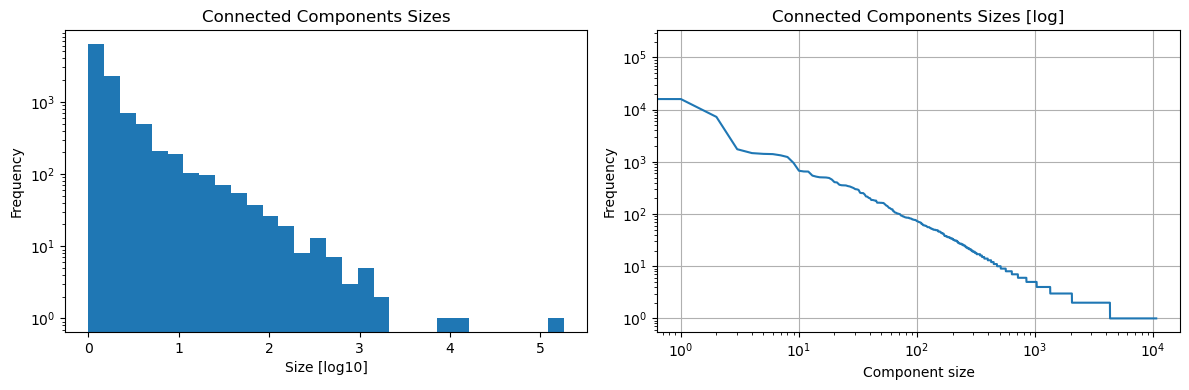

In [4]:
import social_graph

nodes_subset = set(dataset.df_train["ID"].to_list()).union(set(dataset.df_test["ID"].to_list()))

network = social_graph.SocialNetwork(source_file=DATA_PATH + "social_graph.csv")
network.build_from_links(limit=None)
network.prune_from_datasets(dataset_train=dataset.df_train, dataset_test=dataset.df_test, iter_cutoff=1)
network.plot_community_sizes()
# network.compute_node_embeddings(n_components=3)

In [15]:
import random
random_ids = random.sample(network.node_ids, 5)
network.get_node_embeddings(random_ids)

array([[ 6.7235537e-06, -6.1698302e-05, -8.5261185e-04],
       [-4.8584840e-04,  7.6200953e-04,  3.3046200e-04],
       [ 5.5135097e-02, -2.6355423e-02,  4.2292282e-02],
       [-5.5432424e-04, -1.1124460e-03,  1.8858410e-03],
       [-4.8586752e-04,  7.6198374e-04,  3.3040514e-04]], dtype=float32)

In [8]:
import cugraph
H = network.get_subgraph_view(0)
print(f"Subgraph has {H.number_of_edges()} edges and {H.number_of_nodes()} nodes")
components_shortest_paths = nx.all_pairs_shortest_path_length(H, backend="cugraph")

Subgraph has 1335780 edges and 1335750 nodes


In [ ]:
community_idx = 150
subgraph = network.get_subgraph_view(community_idx)
adjacency, laplacian = network.get_graph_adj_lapl_matrices(subgraph=subgraph)
adjacency
# embeddings = network.get_spectral_embeddings(subgraph=subgraph, n_components=4)

<Compressed Sparse Row sparse array of dtype 'float64'
	with 448 stored elements and shape (225, 225)>

In [5]:
embeddings = network.get_spectral_embeddings(subgraph=subgraph, n_components=3)

min_coords = embeddings.min(axis=0)
max_coords = embeddings.max(axis=0)
range_coords = max_coords - min_coords

# Normalize to [0, 1]
range_coords[range_coords == 0] = 1.0
embeddings = (embeddings - min_coords) / range_coords

In [9]:
dataset.df_train.filter(pl.col("ID") == 5956214523393149507)["feature_005"].item()

-0.8448251485824585

In [17]:
network.export_subgraph_dataset_labels_dot(community_idx=30, output_path="social_network_labels.dot", dataset_train=dataset.df_train, dataset_test=dataset.df_test)
!fdp -Tpdf social_network_labels.dot -o network.pdf

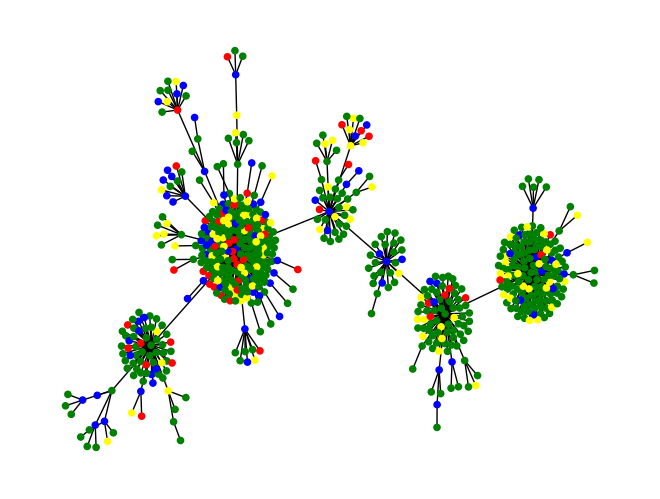

In [6]:
network.plot_subgraph_dataset_labels(community_idx=12, dataset_train=dataset.df_train, dataset_test=dataset.df_test)

In [3]:
community = network.get_subgraph_view(50)
adj_mat, lapl_mat = network.get_graph_adj_lapl_matrices(community)
network.get_spectral_embeddings(community, n_components=3, mode="neighbor", diffuse=False)

array([[ 0.06294815,  0.001702  , -0.00911538],
       [ 0.06294815,  0.001702  , -0.00911538],
       [-0.05750007, -0.10377904, -0.06303461],
       [ 0.06294815,  0.001702  , -0.00911538],
       [ 0.06294815,  0.001702  , -0.00911538],
       [-0.03541873, -0.00529806,  0.15705858],
       [-0.06082178,  0.09960525, -0.0516707 ],
       [-0.06082178,  0.09960525, -0.0516707 ],
       [ 0.07483098,  0.00247412, -0.02243514],
       [ 0.06294815,  0.001702  , -0.00911538],
       [-0.06018476,  0.09757661, -0.04970844],
       [-0.06419793,  0.1110032 , -0.06401858],
       [-0.05750007, -0.10377904, -0.06303461],
       [ 0.07483098,  0.00247412, -0.02243514],
       [ 0.06294815,  0.001702  , -0.00911538],
       [ 0.06294815,  0.001702  , -0.00911538],
       [-0.05750007, -0.10377904, -0.06303461],
       [-0.02904854, -0.0034266 ,  0.05164831],
       [-0.05750007, -0.10377904, -0.06303461],
       [ 0.06294815,  0.001702  , -0.00911538],
       [ 0.06294815,  0.001702  , -0.009

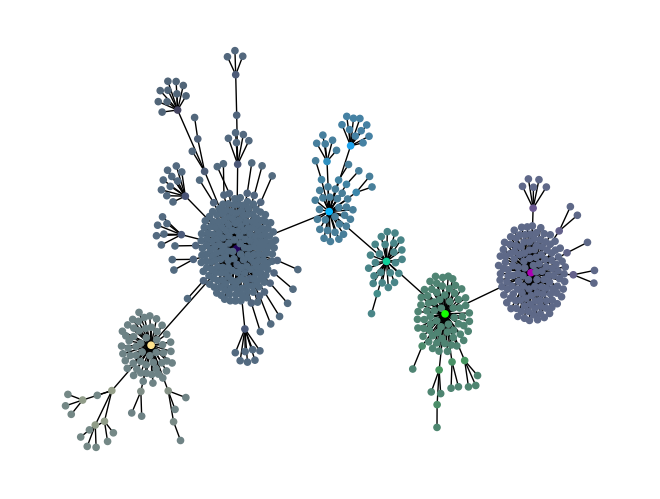

In [6]:
network.plot_subgraph_spectral_structure(community_idx=12, mode="laplacian", diffuse=False)

Subgraph of size 355


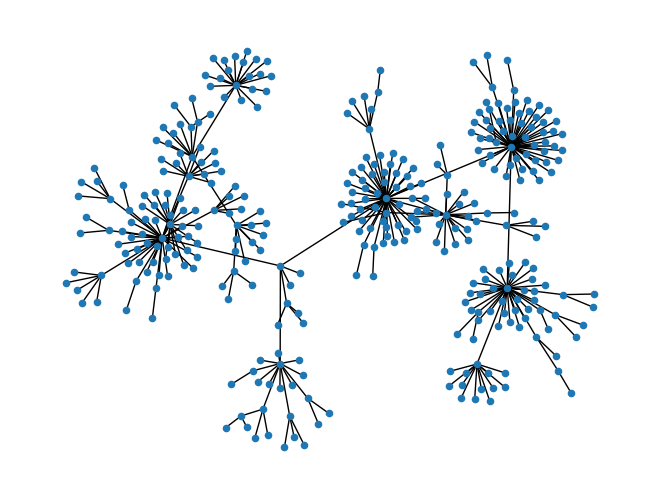

In [34]:
import networkx as nx

subgraph = nx.induced_subgraph(network.graph, network.communities[100])

A_ = nx.to_scipy_sparse_array(
    subgraph, nodelist=subgraph.nodes, dtype=int
).tocsr()

print(f"Subgraph of size {subgraph.size()}")
# nx.draw(subgraph)

import networkx as nx
import matplotlib.pyplot as plt
from networkx.drawing.nx_agraph import graphviz_layout

pos = graphviz_layout(subgraph, prog="sfdp")  # dot, neato, fdp, sfdp, twopi
nx.draw(subgraph, pos, with_labels=False, node_size=20, font_size=10)
plt.show()


In [3]:
dataset.compute_isolate_candidates_from_network(network)

There are 87878 elements in the dataset which are not present in the network.


In [5]:
from scipy.sparse import csgraph

A = nx.to_scipy_sparse_array(
    network.graph, nodelist=network.graph.nodes, dtype=float
).tocsr()
L = csgraph.laplacian(A, normed=True)

print(f"Normalized Laplacian matrix L has shape {L.shape} with {L.nnz} non-zero entries.")

Normalized Laplacian matrix L has shape (1727366, 1727366) with 5146954 non-zero entries.


In [6]:
type(L)

scipy.sparse._coo.coo_array

In [ ]:
from cupyx.scipy.sparse.csgraph import connected_components

components = connected_components(L)

In [30]:
import numpy as np

D = L - L.T
D.nnz, np.allclose(D.data, 0)

(16252, True)

In [ ]:
from scipy.sparse.linalg import eigsh

k = 2  # number of eigenvectors
vals, vecs = eigsh(L, k=k, which='LM', tol=1e-6, maxiter=10)

In [39]:
import cupyx.scipy.sparse as cusp
from cupyx.scipy.sparse.linalg import eigsh

L_gpu = cusp.csr_matrix(L)

vals, vecs = eigsh(L_gpu, k=2, which='LM', tol=1e-6, maxiter=1000)
vecs

array([[-7.51713730e-03, -1.62070089e-03],
       [ 7.17042885e-04,  1.35433152e-04],
       [ 5.76652349e-04,  4.13867316e-04],
       ...,
       [ 1.39767702e-05, -6.34658955e-04],
       [-1.24909278e-05, -5.22619029e-05],
       [ 1.37553979e-04, -2.73080792e-04]], shape=(1727366, 2))

In [ ]:
result = nx.betweenness_centrality(network.graph, k=10)